In [1]:
from skimage.feature import canny, corner_harris, corner_peaks, corner_fast, corner_subpix, match_descriptors, ORB, plot_matches
from skimage.feature import local_binary_pattern as lbp
from scipy.ndimage.morphology import binary_closing
from skimage.transform import warp, AffineTransform, rotate
from skimage.measure import ransac
import skimage.feature
import cv2
from imageio import imread
from skimage.color import rgb2gray
import os
import csv
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib import cm
import numpy as np
from PIL import Image, ImageDraw

from skimage.morphology import binary_opening
from skimage.filters import threshold_otsu, threshold_minimum, threshold_li, threshold_isodata, threshold_mean 
from skimage.filters import gaussian
from skimage.measure import label


Этот порог будет использоваться для преобразования Кэнни:

In [2]:
treshold = 0.4

# Подготовительная часть

In [3]:
# функция, вычисляющая карту границ от изображения
def preprocess(image_path):
    img = imread(image_path)
    img_gray = rgb2gray(img)
    img_edges = canny(img_gray, sigma=2.7, low_threshold=0.01)

    return binary_closing(img_edges, iterations = 3)

# функция для нахождения особых точек на изображении
def find_keypoints(edge_map, r):
    keypoints = corner_peaks(corner_harris(edge_map), threshold_rel=r)
    return keypoints

Подготовим шаблоны к работе. Во-первых, иногда на картинку попадает край листа. Чтобы на него не реагировало преобразование Кэнни, немного обрежем шаблоны. Затем найдем границы объектов для получившихся изображений и по ним построим минимальный описывающий прямоугольник.

In [4]:
templates = os.listdir('objects')
rectangle = {template: None for template in templates}
crop = {template: None for template in templates}

for template in templates:
    # зачитываем шаблоны
    image = imread(f'objects/{template}')
    w, h = len(image[0]), len(image)
    
    # обрезаем края и сохраняем. теперь будем работать с сохраненными шаблонами
    im = PIL.Image.open(f'objects/{template}')
    im_crop = im.crop((30, 200, w-30, h-200))
    im_crop.save(f'cutted_templates/{template}', quality=95)
    
    # вычисляем края для каждого шаблона
    edges = []
    edge_map = preprocess(f'cutted_templates/{template}')
    
    # описываем вокруг каждого предмета минимальный прямоугольник
    nz = np.nonzero(edge_map)
    edges = np.array(list(zip(nz[0], nz[1])))
    
    rectangle[template] = cv2.minAreaRect(edges)

<ipython-input-3-e18d124a2703>:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_gray = rgb2gray(img)


Вот так выгляядат описывающие прямоугольнки. Пока что они описывают предмет вместе с тенью. Это надо будет исправлять.

<ipython-input-3-e18d124a2703>:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_gray = rgb2gray(img)


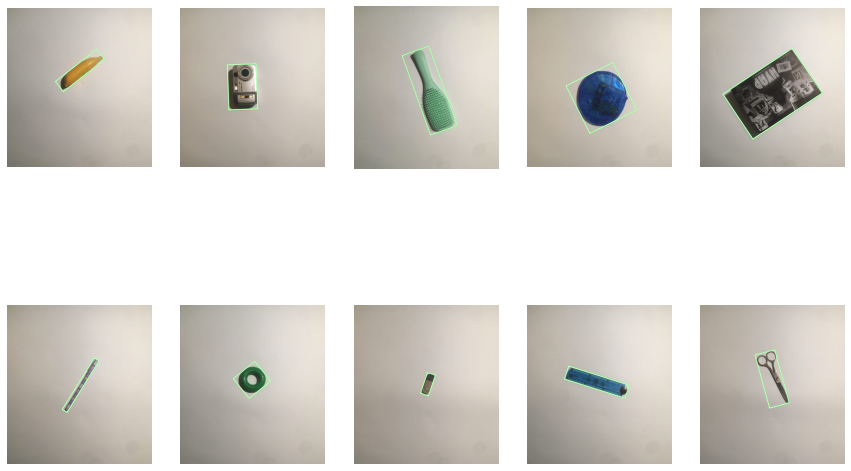

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i in range(10):
    template = imread(f'cutted_templates/{templates[i]}')
    edge_map = preprocess(f'cutted_templates/{templates[i]}')
    rect = rectangle[templates[i]]
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    boxT=np.vstack((box[:,1],box[:,0]))
    boxT=boxT.T

    cv2.drawContours(template, [boxT], 0, (0, 255, 0), 5)

    ax[i//5][i%5].imshow(template)
    ax[i//5][i%5].axis('off')

Теперь обрежем шаблоны по построенным прямоугольникам. Я сначала пыталась использовать обрезанные изображения для матчинга, но не получилось. Зато по ним удобно вычислять размеры описанного прямоугольника -- они нам понадобятся для геометрической части.

In [6]:
# функция поворачивает изображение, чтобы прямоугольник стал параллелен осям координат
def rotate_image(image, center, angle):
  image_center = center 
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, (image.shape[1::-1]), flags=cv2.INTER_LINEAR)
  return result

In [7]:
poly = {template: None for template in templates}
max_dim = {template: None for template in templates}
for template in templates:
    # зачитываем изображение и соотвествующий прямоугольник
    image = imread(f'cutted_templates/{template}')
    rect = rectangle[template]
    
    # поворачиваем изображение
    r_image = rotate_image(image, (rect[0][1], rect[0][0]),  - rect[2])
    
    # обрезаем по измерениям прямоугольника и сохраняем
    rect_c_x = int(rect[0][0]) 
    rect_c_y = int(rect[0][1])
    rect_w = int(rect[1][0])
    rect_h = int(rect[1][1])
    image_cropped = r_image[rect_c_x-rect_w//2 - 1:rect_c_x+rect_w//2 + 1, rect_c_y - rect_h//2 -1 :rect_c_y+rect_h//2 + 1]
    cv2.imwrite(f'crops/{template}', cv2.cvtColor(image_cropped, cv2.COLOR_RGB2BGR))
    
    # теперь мы знаем измерения описывающего прямоугольника
    # сдвигаем прямоугольник в 0, запоминаем координаты, а также максимальное из измерений
    poly[template] = [[0,0], [0, rect_h], [rect_w, rect_h], [rect_w, 0]]
    max_dim[template] = max(rect_w, rect_h)

Вот как обрезаются шаблоны:

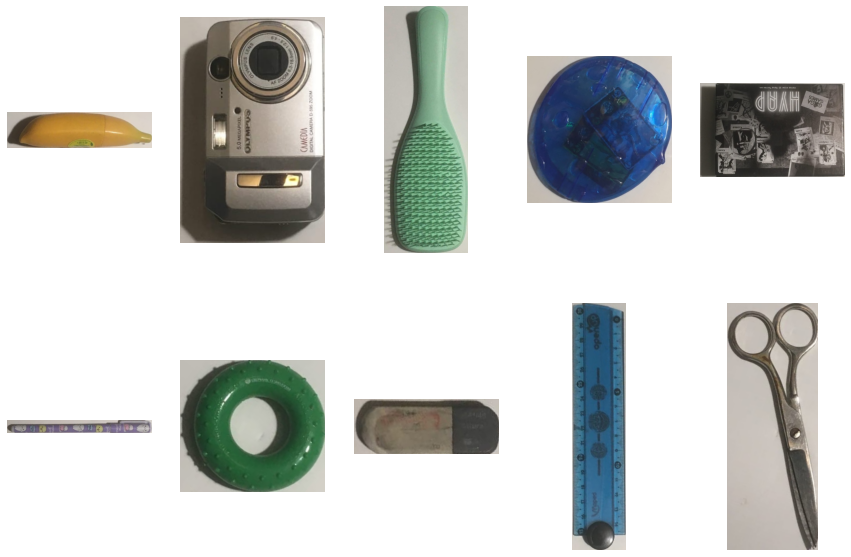

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i in range(10):
    templ = templates[i]
    image = imread(f'cutted_templates/{templ}')
    rect = rectangle[templ]

    angle = rect[0]
    r_image = rotate_image(image, (rect[0][1],rect[0][0]),  - rect[2])

    rect_c_x = int(rect[0][0])
    rect_c_y = int(rect[0][1])
    rect_w = int(rect[1][0])
    rect_h = int(rect[1][1])

    image_cropped = r_image[rect_c_x-rect_w//2 - 1:rect_c_x+rect_w//2 + 1, rect_c_y - rect_h//2 -1 :rect_c_y+rect_h//2 + 1]
    ax[i//5][i%5].imshow(image_cropped)
    ax[i//5][i%5].axis('off')

# Распознавание объектов на фото

Попробуем распознать объекты по текстурным признакам. Для этого порежем входное изображенрие и все шаблоны на патчи, посчитаем GLCM от каждого патча, а затем выберем предметы, для которых корреляция патчей с патчами входного изображения оказалась максимальной.

В этой ячейке разрезаем шаблоны на патчи.

In [413]:
from skimage.feature import greycomatrix, greycoprops

temp_patches = {template: [] for template in templates}
temp_diss = {template: [] for template in templates}

PATCH_SIZE = 90

# режем шаблоны на патчи
for template in templates:        
    templ_img = np.around(rgb2gray(imread(f'crops/{template}'))*255).astype(int)
    templ_h = templ_img.shape[0]
    templ_w = templ_img.shape[1]
    t_h = 0
    while t_h  + PATCH_SIZE< templ_h:
        t_w = 0
        while t_w + PATCH_SIZE < templ_w:
            a = templ_img[t_h:t_h + PATCH_SIZE, t_w:t_w + PATCH_SIZE]
            # вычисляем GLCM от патча
            glcm = greycomatrix(np.around(np.array(a)).astype(int), distances=[0], 
                            angles=[0], levels=256,
                            symmetric=False, normed=True)
            # запоминаем характеристику GLCM, чтобы по ней потом сравнивать
            temp_diss[template].append(greycoprops(glcm, 'ASM'))
            temp_patches[template].append(a)
            t_w += PATCH_SIZE

        t_h += PATCH_SIZE
        

Все то же самое проделываем с входным изображением. Здесь пример для одного из входов.

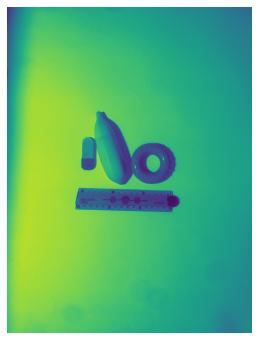

In [399]:
path = 'input/input4'
input_img = os.listdir(path)[1]
img = imread(f'{path}/{input_img}')
img = np.around(rgb2gray(img)*255).astype(int)


fig, ax = plt.subplots(1, 1, figsize=(15,6))

ax.imshow(img)
ax.axis('off')

 
img_w = 3024
img_h = 4032

patches = []
img_diss = []

i_h = 0
while i_h  + PATCH_SIZE< img_h:
    i_w = 0
    while i_w + PATCH_SIZE < img_w:
        a = img[i_h:i_h + PATCH_SIZE, i_w:i_w + PATCH_SIZE]
        glcm = greycomatrix(np.around(np.array(a)).astype(int), distances=[i for i in range(10)],
                        angles=[0], levels=256,
                        symmetric=False, normed=True)
        img_diss.append(greycoprops(glcm, 'contrast'))
        patches.append(a)
        i_w += PATCH_SIZE
   
    i_h += PATCH_SIZE


Теперь сравним все патчи шаблонов с патчами изображения. Выберем тот шаблон, у которого нашелся патч, наиболее близкий к некоторому пачту входа (близкий по характеристике, подсчитанной выше). 

In [400]:
ans = None
norm = 1000000000000000
for j, patch in enumerate(patches):
    for template in templates:
        for i, templ_patch in enumerate(temp_patches[template]):
            res = np.linalg.norm(np.array(temp_diss[template][i]) - np.array(img_diss[j]))
            if abs(res) < norm:
                norm = abs(res)
                ans = template
                
print(ans)                

disk.png


На этом примере на изображении нашелся диск -- ошибка.

Эта функция объединяет в себе 3 предыдущие ячейки. Она возвращает название предмета, который распознался на картинке с помощью текстурных признков. 

In [401]:
def texture(number, PATCH_SIZE, dist, char, angle):
    temp_patches = {template: [] for template in templates}
    temp_diss = {template: [] for template in templates}

    for template in templates:        
        templ_img = np.around(rgb2gray(imread(f'crops/{template}'))*255).astype(int)
        templ_h = templ_img.shape[0]
        templ_w = templ_img.shape[1]
        t_h = 0
        while t_h  + PATCH_SIZE< templ_h:
            t_w = 0
            while t_w + PATCH_SIZE < templ_w:
                a = templ_img[t_h:t_h + PATCH_SIZE, t_w:t_w + PATCH_SIZE]
                glcm = greycomatrix(np.around(np.array(a)).astype(int), distances=[i for i in range(dist)], 
                                angles=[i for i in range(angle)], levels=256,
                                symmetric=False, normed=True)
                temp_diss[template].append(greycoprops(glcm, char))
                temp_patches[template].append(a)
                t_w += PATCH_SIZE

            t_h += PATCH_SIZE
    
    
    path = f'input/input{number}'
    input_img = os.listdir(path)[1]
    img = imread(f'{path}/{input_img}')
    img = np.around(rgb2gray(img)*255).astype(int)

    img_w = 3024
    img_h = 4032

    patches = []
    img_diss = []

    i_h = 0
    while i_h  + PATCH_SIZE< img_h:
        i_w = 0
        while i_w + PATCH_SIZE < img_w:
            a = img[i_h:i_h + PATCH_SIZE, i_w:i_w + PATCH_SIZE]
            glcm = greycomatrix(np.around(np.array(a)).astype(int), distances=[i for i in range(dist)],
                            angles=[i for i in range(angle)], levels=256,
                            symmetric=False, normed=True)
            img_diss.append(greycoprops(glcm, char))
            patches.append(a)
            i_w += PATCH_SIZE

        i_h += PATCH_SIZE
        
        
    ans = None
    norm = 1000000000000000
    for j, patch in enumerate(patches):
        for template in templates:
            for i, templ_patch in enumerate(temp_patches[template]):
                res = np.linalg.norm(np.array(temp_diss[template][i]) - np.array(img_diss[j]))
                if res < norm:
                    norm = res
                    ans = template

    return ans                    
        

Посмотрим, какие результаты она даст на входных изображениях.

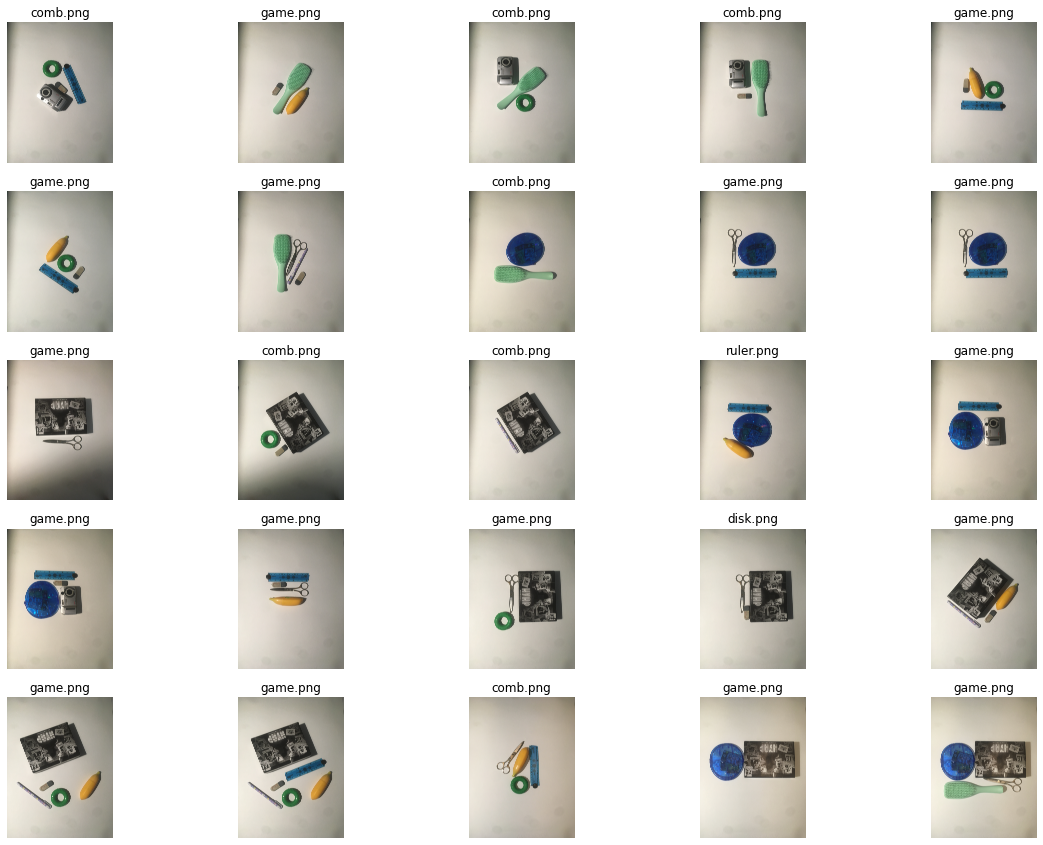

In [412]:
fig, ax = plt.subplots(5, 5, figsize=(20, 15))
for i in range(25):
    path = f'input/input{i}'
    input_img = os.listdir(path)[1]
    img = imread(f'{path}/{input_img}')
    ax[i//5][i%5].imshow(img)
    ax[i//5][i%5].axis('off')
    ax[i//5][i%5].set_title(texture(i, 70, 5, 'ASM', 10))
    

Я надеялась, что с помощью текстурных признаков можно будет распознавать расческу (зубчики образуют узор). Видно, что иногда находятся игра и расческа. Но ни про один предмет нельзя сказать, что если функция его вернула, то он точно есть на картинке. Я проверяла это на разных параметрах GLCM, размерами патчей и с разными метриками разности (там, где мы сравниваем характеристики), но ни разу не получилось что-то приемлемое. Поэтому я считаю, что с помощью GLCM распознавать предметы в этой задаче не удастся. 

Перейдем к следующему методу распознавания.

С помощью ORB найдем особые точки и их дескрипторы для всех шаблонов, а потом и для входного изображения. Здесь я оставила у картинок и шаблонов один цветовой канал: лучшее качество получилось на красном (что странно, потому что красных предметов у нас вообще нет).

In [13]:
orb = ORB(harris_k = 0.005)

def find_kps_and_des(number):
    # зачитываем изображение
    img_name = os.listdir(f'input/input{number}')[1]
    orig_image = imread(f'input/input{number}/{img_name}')
    img = rgb2gray(imread(f'input/input{number}/{img_name}'))
    edge_img = preprocess(f'input/input{number}/{img_name}')
    # сохраняем один из цветовых каналов
    blue_img = orig_image[:,:,0]
    
    
    # вычисляем дескрипторы и особые точки
    orb.detect_and_extract(blue_img)
    in_keypoints = orb.keypoints 
    in_descriptors = orb.descriptors
    return blue_img, edge_img, in_keypoints, in_descriptors


# Находим особые точки и дескрипторы для всех шаблонов
templates = os.listdir('cutted_templates')

kps = {template: None for template in templates}
des = {template: None for template in templates}
edge_map = {template: None for template in templates}
blue_map = {template: None for template in templates}

for template in templates:
    edge_map[template] = preprocess((f'cutted_templates/{template}'))
    blue_map[template] = imread(f'cutted_templates/{template}')[:,:,0]
    keypoints = orb.detect_and_extract(blue_map[template])
    kps[template] = orb.keypoints
    des[template] = orb.descriptors

<ipython-input-3-e18d124a2703>:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_gray = rgb2gray(img)


Для примера вычислим для одного из размеченных изображений.

In [14]:
blue_img, edge_img, in_keypoints, in_descriptors = find_kps_and_des(0)   
np.array(edge_img).shape

(4032, 3024)

Вот такие соответствия получаются при матчинге.(На картинке линии соединяют особые точки фотоаппарата на входной картинке с особыми точками шаблона).

(0.0, 6048.0, 4032.0, 0.0)

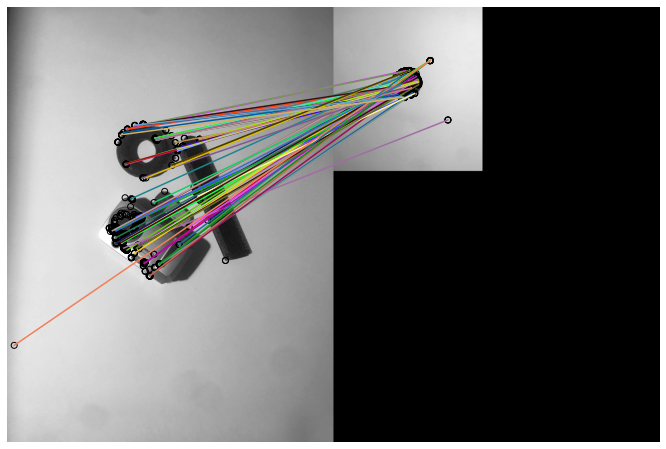

In [15]:
# BFMatcher with default params
matches = match_descriptors(in_descriptors, des[templates[6]], cross_check = True)

fig, ax = plt.subplots(1, 1, figsize=(20,8))

plot_matches(ax, blue_img, blue_map[templates[6]], in_keypoints, kps[templates[6]], matches)
ax.axis('off')


Теперь оценим количество предметов на входной картинке. Для этого бинаризуем ее и посчитаем число компонент связности.

In [484]:
# функция бинаризует изобраение и считает компоненты связности
def find_comp_amount(number):
    # зачитываем изображение
    img_name = os.listdir(f'input/input{number}')[1]
    img = rgb2gray(imread(f'input/input{number}/{img_name}'))
    img = img[400: len(img)-400, :]
    
    # слаживаем и оставляем 1 канал
    img_blur = gaussian(img, sigma=3, multichannel=True)
    img_blur_gray = rgb2gray(img_blur)

    # разные методы бинаризации
    thresh_otsu = threshold_otsu(img_blur_gray)
    thresh_min = threshold_minimum(img_blur_gray)
    thresh_li = threshold_li(img_blur_gray)
    thresh_isodata = threshold_isodata(img_blur_gray)
    thresh_mean = threshold_mean(img_blur_gray)
    
    # получаем бинаризованные изображения
    res_otsu = img_blur_gray <= thresh_otsu
    res_min = img_blur_gray <= thresh_min
    res_li = img_blur_gray <= thresh_li
    res_iso = img_blur_gray <= thresh_isodata
    res_mean = img_blur_gray <= thresh_mean

    # применяем морфологические операции для большей четкости
    otsu = binary_opening(res_otsu, selem=np.ones((25, 25)))
    minim = binary_opening(res_min, selem=np.ones((20, 20)))
    li = binary_opening(res_li, selem=np.ones((30, 30)))
    iso = binary_opening(res_iso, selem=np.ones((40, 40)))
    mean = binary_opening(res_mean, selem=np.ones((30, 30)))

    comp_amount = min(label(otsu, return_num = True)[1], 
                      label(minim, return_num = True)[1], 
                      label(li, return_num = True)[1],
                      label(iso, return_num = True)[1], 
                      label(mean, return_num = True)[1])
    return comp_amount, otsu, minim, li, iso, mean

Посмотрим как она работает с размеченным изображением, рассмотренным выше.

<ipython-input-484-87e5f018bcb4>:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img_blur_gray = rgb2gray(img_blur)


Компонент связности: 6


(-0.5, 3023.5, 3231.5, -0.5)

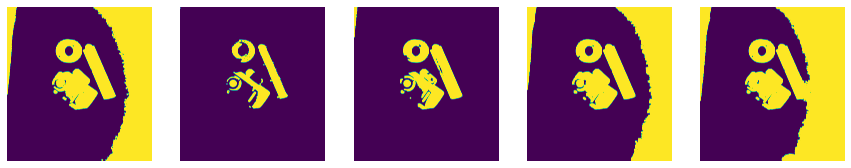

In [485]:
comp_amount, otsu, minim, li, iso, mean = find_comp_amount(0)
print("Компонент связности:", comp_amount)

fig, ax = plt.subplots(1, 5, figsize=(15,6))

ax[0].imshow(otsu)
ax[0].axis('off')

ax[1].imshow(minim)
ax[1].axis('off')

ax[2].imshow(li)
ax[2].axis('off')

ax[3].imshow(iso)
ax[3].axis('off')

ax[4].imshow(mean)
ax[4].axis('off')

Работает почти всегда плохо, потому что неравномерное освещение добавляет новых компонент. Пробовала локальзую бинаризацию, но не помогло. На последней итерации попробовала искать компоненты связности на картах границ, но получилось не сильно лучше, поэтому удалила. Вообще надо работать над матчингом, чтобы в поиске компонент отпала необходимость. Он немного улучшился в этот раз благодаря тому, что был оставлен 1 цветовой канал, но этого пока недостаточно.

Теперь нам необоходимо выявить шаблоны, котоые соотвествуют предметам с картинки. Оставим столько шаблонов, сколько компонент связности получилось. Наиболее подходящие выберем с помощью ransac.

In [487]:
def find_appr_templates(in_descriptors):
    num = []
    for i, template in enumerate(templates):
        matches = match_descriptors(in_descriptors, des[template], cross_check = True)
#        print(template)
#        print(matches)
        src = kps[template][matches[:, 1]]
        dst = in_keypoints[matches[:, 0]]
        
        # ищем преобразование, переводящее как можно больше особых точек шаблона в соответствующие точки картинки
        _, inliers = ransac((src, dst), AffineTransform,
                            min_samples=min(3, len(src)-1), 
                            residual_threshold=2,
                            max_trials=2000)
        
        # считаем для шаблона количество особых точек, которые соответствуют построенной модели
        num.append([np.count_nonzero(inliers), template]) 
    
    num.sort(key = lambda a: a[0], reverse=True)
#    print(num)
    # выбираем наиболее подходящие шаблоны
    
    appr_templates = num[:comp_amount]
    appr_templates = [elem[1] for elem in appr_templates]
    
    #nums = [elem[0] for elem in num]
    #appr_templates = []
    #for i in range(len(num)):
    #    if num[i][0] >= 5:
    #        appr_templates.append(num[i][1])
    
    # сортируем в порядке убывания максимального измерения описывающего прямоугольника
    # нужно для геометрической части
    appr_templates.sort(key = lambda x: max_dim[x], reverse = True)
    return appr_templates

Проверим для нашего примера.

In [488]:
appr_templates = find_appr_templates(in_descriptors)
print(appr_templates)

['ruler.png', 'scissors.png', 'disk.png', 'banana.png', 'camera.png', 'ring.png']


Видно, что часть предметов нашлась правильно. Их получилось больше чем надо из-за неправильного подсчета компонент связности, а один предмет -- кольцо -- не нашелся совсем. На большинстве примеров находится правильно как раз 1-2 предмета.

# Попадание в многоугольник

Вспомогательные функции:

In [489]:
# функция считывает координаты прямоугольника из входных данных
def get_coords(number):
    coordinates = []
    with open(f'input/input{number}/coordinates.csv', 'r') as coords:
        for vertex in csv.reader(coords, delimiter=','):
            coordinates.append(np.int0(vertex).tolist())
    return coordinates        
        
# функция возвращает максимальное из измерений прямоугольника 
def get_max_dim(coordinates):    
    h = coordinates[1][1] - coordinates[0][1]
    w = coordinates[2][0] - coordinates[0][0]
    return max(h, w)

# функция возвращает минимальное из измерений прямоугольника 
def get_min_dim(coordinates):    
    h = coordinates[1][1] - coordinates[0][1]
    w = coordinates[2][0] - coordinates[0][0]
    return min(h, w)  

def get_w(coordinates):
    return coordinates[1][1] - coordinates[0][1]

def get_h(coordinates):
    return coordinates[2][0] - coordinates[0][0]



Пример:

In [490]:
coordinates = get_coords(0)
print(coordinates)

[[0, 0], [0, 1800], [1800, 1800], [1800, 0]]


Функция проверяет, влезают ли объекты в прямоугольник. Работает довольно грубо: "прилаживает" самый большой (по величине максимального измерения) шаблонный прямоугольник длинной стороной сначала к короткой стороне большого прямоугольника. Если все влезает, то отрезаем от длинной стороны соответствующую полоску и берем следующий шаблон. Если не влезло, поворачиваем шаблонный прямоугольник на 90 градусов и пытаемся "приладить" к длинной стороне. Если получилось, отрезаем сооответствующую полоску от короткой стороны и продолжаем со следующим шаблоном. Если не получилось, значит, предмет не влез и можно возвращать 0.

In [491]:
def check_polygon(d1, d2, appr_templates):
    if len(appr_templates) == 0:
        return 1 
    max_poly_dim = max(d1, d2)
    min_poly_dim = min(d1, d2)
    
    for i in range(len(appr_templates)):
        template = appr_templates[i]
        temp = poly[template]
        
        if max_poly_dim < min_poly_dim:
            tmp = max_poly_dim
            max_poly_dim = min_poly_dim
            min_poly_dim = tmp
        
        max_templ_dim = get_max_dim(temp)
        min_templ_dim = get_min_dim(temp)
        
        if max_templ_dim <= min_poly_dim:
            max_poly_dim -= min_templ_dim
        elif max_templ_dim <= max_poly_dim and min_templ_dim <= min_poly_dim:
            min_poly_dim -= min_templ_dim
        else:
            return 0
    return 1

Визуализируем то, что получилось:

In [492]:
from PIL import Image
import scipy

def print_polygon(w, h, appr_templates):
    figure = Image.new('RGB', (w, h), (127,127,127))
    F = 1
    
    if len(appr_templates) == 0:
        figure.save('result/tmp.png')
        plt.imshow(imread('result/tmp.png'))
    
    for i in range(len(appr_templates)):
        max_poly_dim = max(w, h)
        min_poly_dim = min(w, h)
        template = appr_templates[i]
        image = Image.open(f'crops/{template}','r')
        temp = poly[template]
        tw = get_w(temp)
        th = get_h(temp)
        
        max_templ_dim = get_max_dim(temp)
        min_templ_dim = get_min_dim(temp)
        
      
        if max_templ_dim <= min_poly_dim:
            if max_templ_dim == tw and min_poly_dim == w:
                figure.paste(image, ((w - tw)//2 , h - th))
                h -= th
            elif max_templ_dim == th and min_poly_dim == h:
                figure.paste(image, (w - tw , (h - th)//2 ))
                w -= tw
            elif max_templ_dim == th and min_poly_dim == w:
                image2 = image.rotate(90, expand = True)
                figure.paste(image2, ( (w - th)//2, h - tw ))
                h -= tw
            elif max_templ_dim == tw and min_poly_dim == h:
                image2 = image.rotate(90, expand = True)
                figure.paste(image2, ( w - th , (h - tw)//2))
                w -= th
        elif max_templ_dim <= max_poly_dim and min_templ_dim <= min_poly_dim:
            if max_templ_dim == tw and max_poly_dim == w:
                figure.paste(image,  ( (w - tw)//2, h - th))
                h -= th
            elif max_templ_dim == th and max_poly_dim == h:
                figure.paste(image, (w - tw, (h - th)//2))
                w -= tw
            elif max_templ_dim == th and max_poly_dim == w:
                image2 = image.rotate(90, expand = True)
                figure.paste(image2, ( (w - th)//2, h - tw))
                h -= tw
            elif max_templ_dim == tw and max_poly_dim == h:
                image2 = image.rotate(90, expand = True)
                figure.paste(image2, (w - th , (h - tw)//2))
                w -= th
        else:
            print("Не удалось разместить объекты внутри прямоугольника.")
            break
        figure.save(f'result/tmp{i}.png')
        plt.imshow(imread(f'result/tmp{i}.png'))
        plt.axis('off')
    return 1

Проверим на примере:

1

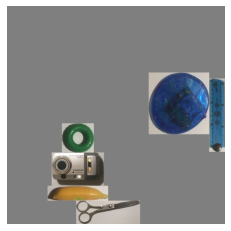

In [493]:
coordinates = get_coords(0)
d1 = get_max_dim(coordinates)
d2 = get_min_dim(coordinates)
w = get_w(coordinates)
h = get_h(coordinates)
check_polygon(d1, d2, appr_templates)
print_polygon(w, h, appr_templates)


Проверим для всех размеченных примеров.

In [494]:
answers = []
for i in range(26):
    blue_img, edge_img, _, in_descriptors = find_kps_and_des(i)   
    comp_amount = find_comp_amount(i)[0]
    appr_templates = find_appr_templates(in_descriptors)
    coordinates = get_coords(i)
    d1 = get_max_dim(coordinates)
    d2 = get_min_dim(coordinates)
    answers.append(check_polygon(d1, d2, appr_templates))
    print(check_polygon(d1, d2, appr_templates))      

<ipython-input-484-87e5f018bcb4>:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img_blur_gray = rgb2gray(img_blur)


1
0
0
1
1
0
1
0
1
1
1
1
1
1
0
1
1
0
1
1
0
0
1
0
1
0


Сравним полученные значения с правильными ответами:

In [495]:
labels = []

with open('labels.csv', 'r') as fh:
    for line in csv.reader(fh, delimiter = '\t'):
        labels.append(line[1])
print(labels)        

['1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0']


Посчитаем качество:

In [496]:
np.sum([answers[i] == int(labels[i]) for i in range(26)])/26

0.8846153846153846

In [497]:
compare = [list(a) for a in zip(labels, answers)]
print(np.array(compare))

[['1' '1']
 ['0' '0']
 ['0' '0']
 ['1' '1']
 ['1' '1']
 ['0' '0']
 ['1' '1']
 ['0' '0']
 ['1' '1']
 ['0' '1']
 ['1' '1']
 ['0' '1']
 ['1' '1']
 ['0' '1']
 ['0' '0']
 ['1' '1']
 ['1' '1']
 ['0' '0']
 ['1' '1']
 ['1' '1']
 ['0' '0']
 ['0' '0']
 ['1' '1']
 ['0' '0']
 ['1' '1']
 ['0' '0']]


Видно, что неправильные ответы получаются только там, где label = 0.

Качество улучшилось по сравнению с предыдущей итерацией. Но все равно остаются проблемы с подсчетом количества компонент связности. Я надеялась уйти от него, улучшив матчинг (и тогда считала бы "найденными" на входной картинке те предметы, на которых соотвествующих особых точек ощутимо больше, чем на остальных), но даже несмотря на улучшенный матчинг четкой границы между предметами картинки и остальными предметами чаще всего не видно. 
